In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns
from scipy import stats

from statsmodels.stats import multitest
import ptitprince as pt
import copy

In [3]:
import popoff
import pop_off_plotting as pop
from pop_off_plotting import color_tt
from Session import SessionLite
from linear_model import PoolAcrossSessions, LinearModel, MultiSessionModel

/home/jrowland/Documents/code/popping-off/popoff/popoff/loadpaths.py
/home/jrowland/Documents/code/Vape


In [4]:
figure_path = '/home/jrowland/Documents/figures/s1s2_paper/0/'

def save_figure(name, base_path='/home/jrowland/mnt/qnap/Figures/josh_thesis'):
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(os.path.join(base_path, f'{name}.pdf'), 
                bbox_inches='tight', transparent=True)

In [5]:
# from matplotlib import rcParams

# params = {'legend.fontsize': 'xx-large',
#          'axes.labelsize': 'xx-large',
#          'axes.titlesize':'xx-large',
#          'xtick.labelsize':'xx-large',
#          'ytick.labelsize':'xx-large'}

# plt.rc("axes.spines", top=False, right=False) # despine

# COLORS = [
# '#228E5E', # Hit green
# '#DB3713', # Miss red
# '#0085BD',  # Correct Rejection
# '#E7A01E', # False postive 
# '#5A1EE7'  # Spont
# ]

# ## MAKE THE FONT SIZE 20 or 21
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['font.size'] = 14


# rcParams.update(params)


In [6]:
msm = MultiSessionModel(remove_targets=False, subsample_sessions=False,
                         remove_toosoon=True)

long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
ALERT SESSIONS NOT SUBSAMPLED
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time
long post time


In [7]:
def get_percent_cells_responding(session, region, direction='positive', prereward=False):

    # 0.015 gives you 5% of cells responding (positive + negative)
    # on cr (for session 0)
    # Get me for 5% across all 
    fdr_rate = 0.015

    if not prereward:
        flu = session.behaviour_trials
    else:
        flu = session.pre_rew_trials
        
    times_use = session.filter_ps_time
    
    if region == 's1':
        flu = flu[session.s1_bool, :, :]
    elif region == 's2':
        flu = flu[session.s2_bool, :, :]
    
    percent_cells_responding = []
    
    magnitude = []

    for trial_idx in range(flu.shape[1]):

        # Haven't built this for 5 Hz data
        assert session.mouse not in ['J048', 'RL048']

        trial = flu[:, trial_idx, :]

        # 500 ms before the stim with a nice 
        # juicy buffer to the artifact just in case
        pre_idx = np.where(times_use < -0.15)[0][-15:]  

        # You can dial this back closer to the artifact if you cut out 150
        post_idx = np.logical_and(times_use > 1, times_use <= 1.5)
        
        pre_array = trial[:, pre_idx]
        post_array = trial[:, post_idx]
        
        p_vals = [stats.wilcoxon(pre, post)[1] for pre, post in zip(pre_array, post_array)]
        p_vals = np.array(p_vals)
        
        sig_cells, correct_pval, _, _ = multitest.multipletests(p_vals, alpha=fdr_rate, method='fdr_bh',
                                                            is_sorted=False, returnsorted=False)
        
        # This doesn't split by positive and negative
#         percent_cells_responding.append(sum(sig_cells))
        
        positive = np.mean(post_array, 1) > np.mean(pre_array, 1)
        negative = np.logical_not(positive)
        
        
        if direction == 'positive':
            percent_cells_responding.append(sum(np.logical_and(sig_cells, positive)))
            magnitude.append(
                np.sum(np.mean(post_array[positive, :], 1) - 
                        np.mean(pre_array[positive, :] , 1))
            )
        else:
            percent_cells_responding.append(sum(np.logical_and(sig_cells, negative)))
        
            magnitude.append(
                np.sum(np.mean(post_array[negative, :], 1) - 
                        np.mean(pre_array[negative, :] , 1))
            )
        
    if region == 's1':
        n = sum(session.s1_bool)
    elif region == 's2':
        n = sum(session.s2_bool)
        
    percent_cells_responding = np.array(percent_cells_responding) / n * 100
    
    assert len(percent_cells_responding) == flu.shape[1]
    assert len(magnitude) == flu.shape[1]
    return percent_cells_responding

In [54]:
def get_data_dict(region):
    
    ''' Gets the percent cells responding across all trials for individual sessions
        Hit and miss trials, only when n_cells_stimmed > 20 (50% behaviour 
        sigmoid threshold)
    '''

    tt_plot = ['hit', 'miss', 'cr', 'fp', 'spont']

    data_dict = {k:[] for k in tt_plot}

    for session_idx in range(len(msm.linear_models)):
        session = msm.linear_models[session_idx].session

        n_responders =  get_percent_cells_responding(session, region, direction='positive')\
                        + get_percent_cells_responding(session, region, direction='negative')

        for tt in tt_plot:

            if tt == 'spont':
                continue

            tt_idx = session.outcome == tt

#             if tt in ['hit', 'miss']:
#                 tt_idx = np.logical_and(tt_idx, session.trial_subsets>20)

            data_dict[tt].append(
                np.mean(n_responders[tt_idx])
            )

        n_responders =  get_percent_cells_responding(session, region, direction='positive', prereward=True)\
                        + get_percent_cells_responding(session, region, direction='negative', prereward=True)

        data_dict['spont'].append(np.mean(n_responders))
    
    data_dict['reward\nonly'] = data_dict.pop('spont')

    return {k:np.array(v) for k, v in data_dict.items()}
    
    

In [99]:
def percent_responding_tts(axes=None):
    
    if axes is None:
        _, axes = plt.subplots(1,2)
    
    for idx, (region, ax) in enumerate(zip(['s1', 's2'], axes)):

        data_dict = get_data_dict(region)
        data_df = pd.DataFrame.from_dict(data_dict)

        boxprops = {'facecolor':'none', "zorder":10}
        sns.boxplot(data=data_df, color='black', width=0.35, boxprops=boxprops, ax=ax)
        sns.stripplot(data=data_df, palette=color_tt, ax=ax)

        if region == 's1':
            ax.set_ylabel('Percent cells responding')
            ax.set_ylim(0, 27)
        else:
            ax.set_ylim(0, 12)
            ax.set_yticks([0,10], [0,10])
        
        alpha = 0.05 / (len(data_dict) - 1)

        print('\n')
        print(region)
        for tt_against in data_dict.keys():

            if tt_against == 'hit':
                continue

            _, p = stats.wilcoxon(data_dict['hit'], data_dict[tt_against])

            # Gets rid of newline for print 
            tt_against = 'reward only' if 'reward' in tt_against else tt_against
            s = f'Hit vs {tt_against}, p = {p}, significant = {p < alpha}'
            print(s)

{'hit': array([24.15918389, 25.02665245, 15.1968133 , 10.46908978, 10.00278474,
        17.26443769, 11.23698459, 20.43123952, 12.16223476, 10.54602799]),
 'miss': array([ 8.5031348 , 13.59275053,  7.25344386,  5.82744907,  5.97182612,
        11.28759398,  9.40342022, 15.27199877,  7.80578898,  8.76110744]),
 'cr': array([5.50106179, 6.68030814, 3.74915101, 2.56006006, 3.05215093,
        7.75      , 5.25301958, 9.84868364, 7.18954248, 5.63702152]),
 'fp': array([ 8.72145096,  6.19977038,  5.67353407,  4.95495495,  4.98304585,
         9.19642857,  6.70553936, 12.49550521,  7.95698925,  8.02122347]),
 'reward\nonly': array([6.67711599, 6.45522388, 3.34565945, 2.82282282, 2.05513784,
        6.23015873, 5.65597668, 9.77346278, 5.76470588, 7.41573034])}

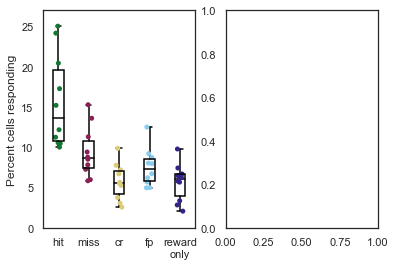

In [46]:
percent_responding_tts()

In [ ]:
1



s1
Hit vs miss, p = 0.001953125, significant = True
Hit vs cr, p = 0.001953125, significant = True
Hit vs fp, p = 0.001953125, significant = True
Hit vs reward only, p = 0.001953125, significant = True


s2
Hit vs miss, p = 0.048828125, significant = False
Hit vs cr, p = 0.00390625, significant = True
Hit vs fp, p = 0.037109375, significant = False
Hit vs reward only, p = 0.001953125, significant = True


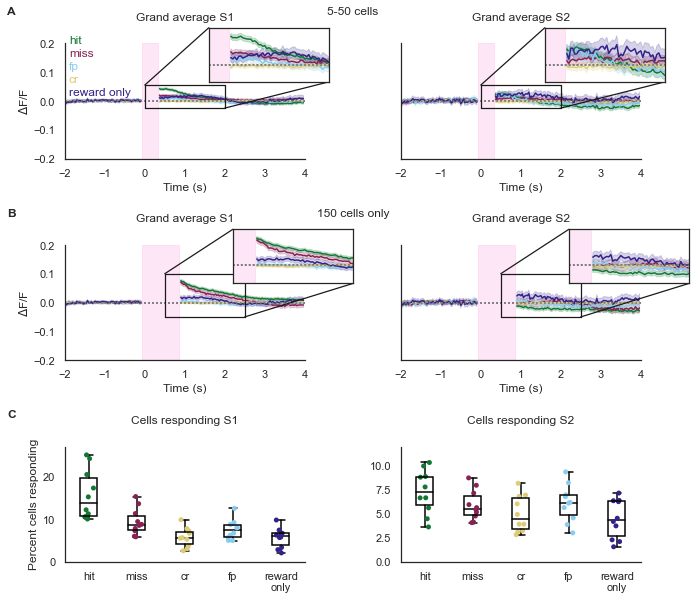

In [100]:
fig = plt.figure(constrained_layout=False, figsize=(8, 8))

tts = ['hit', 'miss', 'fp', 'cr', 'pre_reward']

without_150 = fig.add_gridspec(ncols=2, nrows=1, bottom=0.8, top=1, right=1, left=0,
                               wspace=0.4, hspace=0.7)

only_150 = fig.add_gridspec(ncols=2, nrows=1, bottom=0.45, top=0.65, right=1, left=0,
                            wspace=0.4, hspace=0.7)

rains = fig.add_gridspec(ncols=2, nrows=1, bottom=0.1, top=0.3, right=1, left=0,
                            wspace=0.4, hspace=0.7)

fig.text(0.5, 1.05, '5-50 cells', ha="center")
fig.text(0.5, 0.7, '150 cells only', ha="center")


ax_pop_activity = {xx: fig.add_subplot(without_150[xx]) for xx in range(2)}

for n_cells in [[5, 10, 20, 30, 40, 50]]:
    tmp = pop.plot_average_tt_s1_s2(msm, n_cells, tts_plot=tts,
                                   ax_s1=ax_pop_activity[0], ax_s2=ax_pop_activity[1],
                                   plot_legend=True)
    
ax_pop_activity[0].set_title('Grand average S1', y=1.15)#, fontsize=20)
ax_pop_activity[1].set_title('Grand average S2', y=1.15)#, fontsize=20)
    
ax_pop_activity = {xx: fig.add_subplot(only_150[xx]) for xx in range(2)}

for n_cells in [[150]]:
    tmp = pop.plot_average_tt_s1_s2(msm, n_cells, tts_plot=tts,
                                   ax_s1=ax_pop_activity[0], ax_s2=ax_pop_activity[1],
                                   plot_legend=False, zoom_ylims=(-0.05, 0.1))
    
ax_pop_activity[0].set_title('Grand average S1', y=1.15)#, fontsize=20)
ax_pop_activity[1].set_title('Grand average S2', y=1.15)#, fontsize=20)

ax_rains = [fig.add_subplot(rains[xx]) for xx in range(2)]
pop.despine(ax_rains[0])
pop.despine(ax_rains[1])

percent_responding_tts(ax_rains)

ax_rains[0].set_title('Cells responding S1', y=1.15)#, fontsize=20)
ax_rains[1].set_title('Cells responding S2', y=1.15)#, fontsize=20)

fig.text(s='A', x=-0.1, y=1.05, fontdict={'weight': 'bold'})
fig.text(s='B', x=-0.1, y=0.7, fontdict={'weight': 'bold'})
fig.text(s='C', x=-0.1, y=0.35, fontdict={'weight': 'bold'})

save_fig = True
if save_fig:
    plt.savefig(os.path.expanduser('~/Documents/code/popping-off/figures/full_figs_manuscript/fig2_supp_traces_boxs.pdf'),
               bbox_inches='tight')